#Fashion Dataset

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

!pip install ipython-autotime
%load_ext autotime

  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


### Acquiring Fashion Dataset

In [0]:
### Acquiring Kimia Lab Histopathology Image Dataset
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step
time: 3.92 s


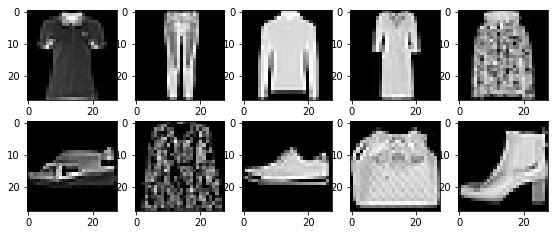

time: 970 ms


In [0]:
# Checking distribution of labels
Label_map = {}
for i, y in enumerate(y_train):
  if y in Label_map:
    Label_map[y].append(i)
  else:
    Label_map[y] = [i]

# View 12 random images with specific label
rows = 2
columns = 5
scale_factor = 15

def ShowImages():
  # Doesn't actually shuffle the training set
  figsize_x = x_train[0].shape[1] * columns / scale_factor
  figsize_y = x_train[0].shape[0] * rows / scale_factor
  fig = plt.figure(figsize=(figsize_x, figsize_y))
  for i in range(1, columns*rows +1):
    np.random.shuffle(Label_map[i - 1])
    fig.add_subplot(rows, columns, i)
    img_index = Label_map[i - 1][0]
    plt.imshow(x_train[img_index], cmap='gray')
  plt.show()

ShowImages()

In [0]:
for i in range(0, 10):
  print(len(Label_map.get(i)))

6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
time: 2.2 ms


In [0]:
def convertOneHot(labels, num_classes):
  return np.array([np.eye(num_classes)[label] for label in labels])

# Normalize images and add channel axis
X_train = (x_train/255)[..., np.newaxis] 
X_test = (x_test/255)[..., np.newaxis] 

# Convert labels to one hot
num_classes = max(y_train) + 1
Classes = np.unique(y_train)
Y_train = convertOneHot(y_train, num_classes)
Y_test = convertOneHot(y_test, num_classes)

print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28, 1)
(60000, 10)
time: 617 ms


# Single Classifier

In [0]:
def build_and_train(x_train, y_train, model=None, epochs=25):
  # Randomly break off data for validation
  x_t, x_v, y_t, y_v = train_test_split(x_train, y_train)
  
  # Performing image augmentations
  # Augment test images
  train_datagen = keras.preprocessing.image.ImageDataGenerator(
      horizontal_flip=True,
  )

  if model == None:
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_train[0].shape),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(momentum=0.1),
        keras.layers.MaxPool2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(momentum=0.1),
        keras.layers.MaxPool2D((2, 2)),

        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(rate=0.25),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(y_train[0].shape[0]),
    ]);
  
  # Training model
  Best_model = 'best_model.h5'
  
  optimizer = tf.train.AdamOptimizer()
  model.compile(optimizer=optimizer, loss=tf.losses.softmax_cross_entropy, metrics=['accuracy'])

  # Set callback functions to early stop training and save the best model so far
  callbacks = [keras.callbacks.ModelCheckpoint(filepath=Best_model, monitor='val_acc', save_best_only=True)]
  
  model.fit_generator(
    train_datagen.flow(x_t, y_t, batch_size=32),
    steps_per_epoch=len(x_t) / 16,
    epochs=epochs,
    validation_data=(x_v, y_v),
    callbacks=callbacks,
  )
  
  best = keras.models.load_model(Best_model)
  best.compile(optimizer=optimizer, loss=tf.losses.softmax_cross_entropy, metrics=['accuracy'])
  return best

time: 27.1 ms


In [0]:
best = build_and_train(X_train, Y_train)

# Evaluate models
results = best.evaluate(X_test, Y_test)
print(best.metrics_names)
print(results)

Epoch 1/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5515 - acc: 0.7992 - val_loss: 0.3800 - val_acc: 0.8612
Epoch 2/25
1407/1407 [==============================] - 12s 9ms/step - loss: 0.3714 - acc: 0.8660 - val_loss: 0.3608 - val_acc: 0.8679
Epoch 3/25
1407/1407 [==============================] - 12s 9ms/step - loss: 0.3255 - acc: 0.8829 - val_loss: 0.3253 - val_acc: 0.8821
Epoch 4/25
1407/1407 [==============================] - 12s 8ms/step - loss: 0.2981 - acc: 0.8935 - val_loss: 0.2965 - val_acc: 0.8917
Epoch 5/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.2756 - acc: 0.9007 - val_loss: 0.3020 - val_acc: 0.8921
Epoch 6/25
1407/1407 [==============================] - 12s 9ms/step - loss: 0.2600 - acc: 0.9057 - val_loss: 0.2862 - val_acc: 0.8953
Epoch 7/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.2453 - acc: 0.9112 - val_loss: 0.2692 - val_acc: 0.9015
Epoch 8/25
1407/1407 [==============================] 

Confusion matrix, without normalization
[[847   3  31  15   5   1  92   0   6   0]
 [  0 972   2  17   2   0   5   0   2   0]
 [ 11   0 883   6  51   0  47   0   2   0]
 [ 10   2  25 901  28   0  29   0   4   1]
 [  0   0  45  24 885   0  44   0   2   0]
 [  0   0   0   1   0 955   0  26   0  18]
 [ 95   1  88  15  92   0 700   0   9   0]
 [  0   0   0   0   0   5   0 975   0  20]
 [  2   0   2   4   7   4   4   1 975   1]
 [  0   0   0   0   0   6   0  36   0 958]]


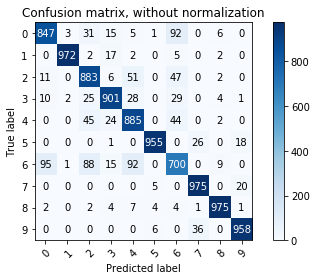

time: 19.1 s


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  
Y_pred = best.predict(X_test, batch_size=1)
plot_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), Classes)

plt.show()

# Classifier Tree

In [0]:
def buildClassDict(class_groups):
  class_dict = {}
  for i, group in enumerate(class_groups):
    for val in group:
      class_dict[val] = i
  return class_dict

def remapAndFilter(data, labels, class_dict, class_groups):
  new_labels = []
  new_data = []
  for idx, label in enumerate(labels):
    if label in class_dict:
      new_label = class_dict[label]
      new_labels.append(new_label)
      new_data.append(data[idx])
  
  return np.array(new_data), convertOneHot(new_labels, len(class_groups))

time: 9.04 ms


In [0]:
Class_groups = [[0, 1, 2, 3, 4, 6], [5, 7, 9], [8]]
Class_dict = buildClassDict(Class_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, y_train, Class_dict, Class_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, y_test, Class_dict, Class_groups)

root = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = root.evaluate(remapped_x_test, remapped_y_test)
print(root.metrics_names)
print(results)

Epoch 1/25
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0530 - acc: 0.9849 - val_loss: 0.0605 - val_acc: 0.9857
Epoch 2/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0290 - acc: 0.9922 - val_loss: 0.0370 - val_acc: 0.9904
Epoch 3/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.0222 - acc: 0.9938 - val_loss: 0.0263 - val_acc: 0.9926
Epoch 4/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0189 - acc: 0.9945 - val_loss: 0.0424 - val_acc: 0.9905
Epoch 5/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0174 - acc: 0.9956 - val_loss: 0.0183 - val_acc: 0.9939
Epoch 6/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0162 - acc: 0.9956 - val_loss: 0.0202 - val_acc: 0.9934
Epoch 7/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0141 - acc: 0.9960 - val_loss: 0.0239 - val_acc: 0.9937
Epoch 8/25
1407/1407 [==============================]

In [0]:
Cloth_groups = [[x] for x in Class_groups[0]]
Cloth_dict = buildClassDict(Cloth_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, y_train, Cloth_dict, Cloth_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, y_test, Cloth_dict, Cloth_groups)

cloth = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = cloth.evaluate(remapped_x_test, remapped_y_test)
print(cloth.metrics_names)
print(results)

Epoch 1/25
844/844 [==============================] - 12s 14ms/step - loss: 0.6371 - acc: 0.7559 - val_loss: 0.5094 - val_acc: 0.8073
Epoch 2/25
844/844 [==============================] - 8s 10ms/step - loss: 0.4593 - acc: 0.8268 - val_loss: 0.4422 - val_acc: 0.8327
Epoch 3/25
844/844 [==============================] - 8s 9ms/step - loss: 0.4075 - acc: 0.8477 - val_loss: 0.3963 - val_acc: 0.8518
Epoch 4/25
844/844 [==============================] - 8s 9ms/step - loss: 0.3740 - acc: 0.8594 - val_loss: 0.3831 - val_acc: 0.8568
Epoch 5/25
844/844 [==============================] - 8s 9ms/step - loss: 0.3457 - acc: 0.8723 - val_loss: 0.3852 - val_acc: 0.8560
Epoch 6/25
844/844 [==============================] - 8s 9ms/step - loss: 0.3282 - acc: 0.8783 - val_loss: 0.3812 - val_acc: 0.8572
Epoch 7/25
844/844 [==============================] - 8s 9ms/step - loss: 0.3072 - acc: 0.8854 - val_loss: 0.3549 - val_acc: 0.8688
Epoch 8/25
844/844 [==============================] - 8s 9ms/step - loss:

In [0]:
Shoes_groups = [[5], [7], [9]]
Shoes_dict = buildClassDict(Shoes_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, y_train, Shoes_dict, Shoes_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, y_test, Shoes_dict, Shoes_groups)

shoes = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = shoes.evaluate(remapped_x_test, remapped_y_test)
print(shoes.metrics_names)
print(results)

Epoch 1/25
422/422 [==============================] - 8s 20ms/step - loss: 0.2610 - acc: 0.9030 - val_loss: 0.1739 - val_acc: 0.9369
Epoch 2/25
422/422 [==============================] - 4s 9ms/step - loss: 0.1632 - acc: 0.9416 - val_loss: 0.1458 - val_acc: 0.9533
Epoch 3/25
422/422 [==============================] - 4s 9ms/step - loss: 0.1298 - acc: 0.9544 - val_loss: 0.1395 - val_acc: 0.9496
Epoch 4/25
422/422 [==============================] - 4s 9ms/step - loss: 0.1192 - acc: 0.9585 - val_loss: 0.1189 - val_acc: 0.9598
Epoch 5/25
422/422 [==============================] - 4s 10ms/step - loss: 0.1005 - acc: 0.9633 - val_loss: 0.1103 - val_acc: 0.9613
Epoch 6/25
422/422 [==============================] - 4s 9ms/step - loss: 0.0961 - acc: 0.9654 - val_loss: 0.1143 - val_acc: 0.9589
Epoch 7/25
422/422 [==============================] - 4s 9ms/step - loss: 0.0909 - acc: 0.9676 - val_loss: 0.1049 - val_acc: 0.9642
Epoch 8/25
422/422 [==============================] - 4s 10ms/step - loss:

### Combining Individual Classifiers

In [0]:
from sklearn.metrics import accuracy_score
from scipy.special import softmax

def predict(x):
  y_root = root.predict(x)
  y_shoes = shoes.predict(x)
  y_cloth = cloth.predict(x)
  
  y_pred = []
  for (y_r, y_s, y_c) in zip(y_root, y_shoes, y_cloth):
    # Normalize Predictions
    y_r = softmax(y_r)
    y_c = softmax(y_c)
    y_s = softmax(y_s)
    
    y = np.zeros(num_classes)
    y[8] = y_r[Class_dict[8]]
    
    for i in Class_groups[0]:
      y[i] = y_r[0] * y_c[Cloth_dict[i]]
      
    for i in Class_groups[1]:
      y[i] = y_r[1] * y_s[Shoes_dict[i]]
       
    y_pred.append(y)
 
  return y_pred
    
y_pred = predict(X_test)
y_labels = [np.argmax(pred) for pred in y_pred]

accuracy_score(y_test, y_labels)

0.9113

time: 3.98 s


# Mixing Classifiers

In [0]:
# Root classifier
Class_groups = [[0, 2, 3, 4, 6], [1], [5, 7, 9], [8]]
Class_dict = buildClassDict(Class_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, y_train, Class_dict, Class_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, y_test, Class_dict, Class_groups)

model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=remapped_x_train[0].shape),
    keras.layers.BatchNormalization(momentum=0.1),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(remapped_y_train[0].shape[0]),
]);

root = build_and_train(remapped_x_train, remapped_y_train, model, 5)

# Evaluate model
results = root.evaluate(remapped_x_test, remapped_y_test)
print(root.metrics_names)
print(results)

In [0]:
# Cloth classifier
Cloth_groups = [[0], [2], [3], [4], [6]]
Cloth_dict = buildClassDict(Cloth_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, y_train, Cloth_dict, Cloth_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, y_test, Cloth_dict, Cloth_groups)

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=remapped_x_train[0].shape),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(remapped_y_train[0].shape[0]),
]);

cloth = build_and_train(remapped_x_train, remapped_y_train, model, 20)

# Evaluate model
results = cloth.evaluate(remapped_x_test, remapped_y_test)
print(cloth.metrics_names)
print(results)

In [0]:
# Shoe classifier
Shoes_groups = [[5], [7], [9]]
Shoes_dict = buildClassDict(Shoes_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, y_train, Shoes_dict, Shoes_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, y_test, Shoes_dict, Shoes_groups)


model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=remapped_x_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(remapped_y_train[0].shape[0]),
]);

shoes = build_and_train(remapped_x_train, remapped_y_train, model, 10)

# Evaluate model
results = shoes.evaluate(remapped_x_test, remapped_y_test)
print(shoes.metrics_names)
print(results)